## Bayesian errors-in-variables estimation of specific climate sensitivity
#### D. Heslop, E. J. Rohling, G. L. Foster, and J. Yu

#### Notebook to estimate Eocene climate sensitivity via Bayesian EIV (recreates Figures 5 and 6).

#### Import require libraries (installation of emcee from here: https://pypi.org/project/emcee/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, uniform, gaussian_kde
import emcee
import pathos.multiprocessing as mp
import pandas as pd

If you have TeX installed these commands will produce LaTeX-formatted plots. If you don't have TeX, then don't execute the commands.

In [2]:
# Enable LaTeX rendering in Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

Read in the CenCO2PIP ln(CO2) data (500kyr windows)

In [3]:
CO2 = pd.read_csv("500kyrCO2.csv")

Read in the CenCO2PIP $\Delta$GMST data (500kyr windows)

In [4]:
DT = pd.read_csv("500kyrTemp.csv")
age = np.array(DT['ages'].values) #get the 

The uncertainties in ln(CO2) and $\Delta$GMST are approximatly Gaussian. Use moment-matching to estimate the mean and standard deviation of the data and uncertainties

In [5]:
q = np.array([0.025,0.25,0.5,0.75,0.975]); #quantiles used in CenCO2PIP uncertainty representation 

def moment_sse(x,q,X0): 
    
    #objective function to find normal distribution that best matches the provided quantiles
    
    ## INPUTS
    # x = [mean,std] of proposed normal distribution
    # q = quantiles under consideration
    # X0 = values for the quantiles in q
    
    ## OUTPUT
    # sse = sum of squared errors of X values and normal distribution predictions for quantiles
    
    sse = np.sum((norm.ppf(q, loc=p0[0], scale=p0[1])-X0[1:])**2)
    
    return sse

Loop through the CO2 windows performing moment matching

In [6]:
CO20 = np.array(CO2.values)
n_CO20 = np.shape(CO20)[0]
CO2norm = np.zeros((n_CO20,2)) #preallocate array to store mean and std of normal distributions
for i in range(n_CO20): #loop through the CO2 values
    p0 = np.array([CO20[i,3],(CO20[i,-1]-CO20[i,1])/(2*1.96)]) #initial guess of mean and std based on quantiles
    CO2norm[i,:] = minimize(moment_sse, p0, args=(q,CO20[i,:])).x #minimise sse and output solution

Loop through the $\Delta$GMST windows performing moment matching

In [7]:
DT0 = np.array(DT.values)
n_DT0 = np.shape(DT0)[0]
DTnorm = np.zeros((n_DT0,2)) #preallocate array to store mean and std of normal distributions
for i in range(n_DT0): #loop through the CO2 values
    p0 = np.array([DT0[i,3],(DT0[i,-1]-DT0[i,1])/(2*1.96)]) #initial guess of mean and std based on quantiles
    DTnorm[i,:] = minimize(moment_sse, p0, args=(q,DT0[i,:])).x #minimise sse and output solution

Select age windows within the interval 54 to 35 Ma

In [9]:
idx = np.argwhere((age>=35) & (age<=54))

Make percentile comparison plots with ln(CO2) and $\Delta$GMST

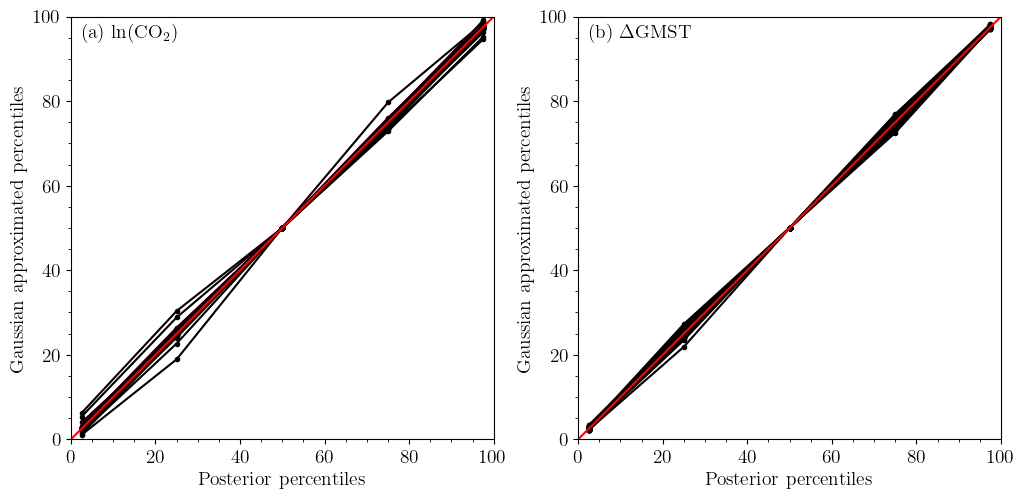

In [11]:
fig = plt.figure(figsize=(12,6))

# Plot ln(CO2) percentiles 
plt.subplot(1,2,1)
for i in idx:
    hat = norm.cdf(CO20[i,1:],loc=CO2norm[i,0],scale=CO2norm[i,1])*100 #find Gaussian approximation percentiles
    plt.plot(np.array([2.5,25,50,75,97.5]),np.squeeze(hat),'.-k')

fontsize = 14
plt.xlim([0,100])
plt.ylim([0,100])
plt.plot([0,100],[0,100],'r-',linewidth=1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlabel('Posterior percentiles',fontsize=fontsize)
plt.ylabel('Gaussian approximated percentiles',fontsize=fontsize)
plt.text(2.5,95,'(a) ln(CO$_2$)',fontsize=fontsize)

# Plot DGMST percentiles
plt.subplot(1,2,2)
for i in idx:
    hat = norm.cdf(DT0[i,1:],loc=DTnorm[i,0],scale=DTnorm[i,1])*100 #find Gaussian approximation percentiles
    plt.plot(np.array([2.5,25,50,75,97.5]),np.squeeze(hat),'.-k')

fontsize = 14
plt.xlim([0,100])
plt.ylim([0,100])
plt.plot([0,100],[0,100],'r-',linewidth=1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlabel('Posterior percentiles',fontsize=fontsize)
plt.ylabel('Gaussian approximated percentiles',fontsize=fontsize)
plt.text(2.5,95,'(b) $\Delta$GMST',fontsize=fontsize);

Convert CO2norm into R forcing and select X and Y data points with uncertainties

In [12]:
CO2norm[:,0] = 5.35*(CO2norm[:,0]-np.log(280)) #forcing
CO2norm[:,1] = 5.35*CO2norm[:,1] #forcing uncertainty

x_sigmas0 = np.squeeze(CO2norm[idx,1]) #x-value standard deviations
y_sigmas0 = np.squeeze(DTnorm[idx,1]) #y-value standard deviations
    
x_mus0 = np.squeeze(CO2norm[idx,0]) #x-value means
y_mus0 = np.squeeze(DTnorm[idx,0]) #y-value means

Define the functions to find the likelihood, negative loglikelihood, and perform the numerical integration

In [13]:
def loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims):

    #INPUTS
    #ypts = y-values of regression line at xlims values
    #x_mus = array of data point x-values
    #x_sigmas = array of data point x-value uncertainty standard deviations
    #y_mus = array of data point y-values
    #y_sigmas = array of data point y-value uncertainty standard deviations
    #xlims = x limits for numerical integration 
    
    xpts = np.linspace(xlims[0],xlims[1],len(ypts))     
    p = np.polyfit(xpts,ypts,len(ypts)-1)
    xts = np.linspace(xpts[0],xpts[-1],2000)
    yts = np.polyval(p,xts)
    t = np.sqrt((xts[:-1]-xts[1:])**2+(yts[:-1]-yts[1:])**2)
    
    L = 0    
    for x_mu, x_sigma, y_mu, y_sigma in zip(x_mus,x_sigmas,y_mus,y_sigmas):
        temp = norm.logpdf(xts,loc=x_mu,scale=x_sigma)+norm.logpdf(yts,loc=y_mu,scale=y_sigma)
        Li = log_trapz(temp,t)
        L += Li        

    return L

def negloglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims):
    
    #INPUTS
    #ypts = y-values of regression line at xlims values
    #x_mus = array of data point x-values
    #x_sigmas = array of data point x-value uncertainty standard deviations
    #y_mus = array of data point y-values
    #y_sigmas = array of data point y-value uncertainty standard deviations
    #xlims = x limits for numerical integration 
    
    return -loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims)

def log_trapz(y,dx):

    #intergrate using trapezoidal rule working in terms of logs
    #INPUTS
    #y = log of input array to integrate
    #dx = spacing between points
    
    n = len(y)
    a = np.max(y)
    ya = np.exp(y-a)    
    temp = (ya[:-1]+ya[1:])/2*dx
    
    return a + np.log(np.sum(temp))

Fit the OLS and MLE regression models: note ```pNLL0``` is the y-values of the line at ```xlims``` rather than polynomial coefficients

In [14]:
xlims = np.array([0,15])
pOLS0 = np.polyfit(x_mus0,y_mus0,1) #OLS model
pNLL0 = minimize(negloglike, np.polyval(pOLS0,xlims), args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims),method='SLSQP').x #MLE model

Plot the results

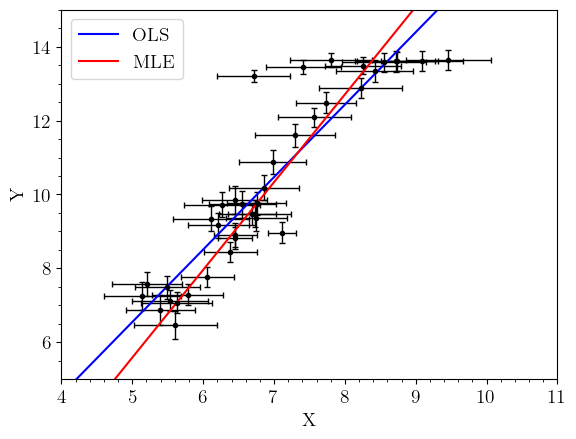

In [15]:
fontsize=14
#plot the data
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel('X',fontsize=fontsize)
plt.ylabel('Y',fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot(xlims,np.polyval(pOLS0,xlims),'-b',label='OLS')
plt.plot(xlims,pNLL0,'-r',label='MLE')

plt.xlim([4,11])
plt.ylim([5,15])

plt.legend(fontsize=fontsize)

### Use emcee to sample posterior distribution

Set the y-limits at xlims that define the prior on the regression line

In [16]:
ylims = np.array([-1000,1000])

Define prior as a function, returning the value of the prior for given y end-points of the regression line

In [17]:
def log_prior(ypts,ylims):
    lp = np.sum(uniform.pdf(ypts, loc=ylims[0], scale=ylims[1]))   
    return lp

Define a function that combines the prior with the likelihood (see emcee documentation)

In [18]:
def log_probability(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xpts, ylims):
    
    lp = log_prior(ypts,ylims)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims)

Setup the emcee initalization based on the MLE solution (see emcee documentation)

In [19]:
pos = pNLL0 + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

Setup and run the sampler (20000 iterations) using multithreading for speed (see emcee documentation

In [20]:
pool = mp.ProcessPool(nodes=16)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, pool = pool, args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims, ylims))

sampler.run_mcmc(pos, 20000, progress=True);

100%|█████████████████████████████████████| 20000/20000 [15:14<00:00, 21.87it/s]


Estimate the chain integrated autocorrelation length in terms of steps

In [26]:
tau = sampler.get_autocorr_time()
print(int(np.ceil(np.mean(tau))))

33


Arrange the samples into a 2D array, discard the burnin and thinning samples

In [21]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(12160, 2)


The sampler gives distributions of y values at the regression line end-points. Loop through and convert first 10000 samples to polynomial coefficients

In [27]:
flat_samples = flat_samples[0:10000,:]
pMCMC = []
for i in range(flat_samples.shape[0]):
    pMCMC.append(np.polyfit(xlims,flat_samples[i,:],1))
pMCMC = np.asarray(pMCMC)

Loop through the coefficients to find the 95% confidence intervals of the lines as a function of x 

In [28]:
xplot = np.linspace(xlims[0],xlims[-1])
nsamples = np.shape(pMCMC)[0]
temp = np.zeros((nsamples,len(xplot))) 
for i in range(nsamples):
    temp[i,:] = np.polyval(pMCMC[i,:],xplot)
MCMC_CI = np.percentile(temp,[2.5,50,97.5],axis=0).T

### Estimate the OLS fit uncertainty based parametric bootstrapping of x and y uncertainties

In [29]:
niter = 10000
temp = np.zeros((niter,len(xplot)))
pOLS = []
for i in range(niter):
    xi = x_mus0+np.random.randn(len(x_mus0))*x_sigmas0
    yi = y_mus0+np.random.randn(len(y_mus0))*y_sigmas0
    p = np.polyfit(xi,yi,1)
    temp[i,:] = np.polyval(p,xplot)
    pOLS.append(p)

pOLS = np.array(pOLS)
OLS_CI = np.percentile(temp,[2.5,50,97.5],axis=0).T

### Define function to find the MAP of the posterior distribution using kernel density estimation

In [30]:
def find_MAP(samples):
    kde = gaussian_kde(samples)
    
    # Create an array of values over which to evaluate the KDE
    x_vals = np.linspace(min(samples), max(samples), 1000)
    kde_vals = kde(x_vals)
    
    # Find the peak of the KDE
    map_index = np.argmax(kde_vals)
    return x_vals[map_index]    

### Define function to find the credible interval of a collection of samples

In [31]:
def credible(samples,credible_level):

    # Sort the samples
    sorted_samples = np.sort(samples)
    
    # Determine the credible level and number of samples
    N = len(sorted_samples)
    N_credible = int(credible_level * N)
    
    # Compute the HDR
    intervals = [(sorted_samples[i], sorted_samples[i + N_credible - 1]) for i in range(N - N_credible + 1)]
    ranges = [interval[1] - interval[0] for interval in intervals]
    min_range_index = np.argmin(ranges)
    
    # HDR boundaries
    hdr_interval = intervals[min_range_index]
    
    return np.array(hdr_interval)

### Plot the results

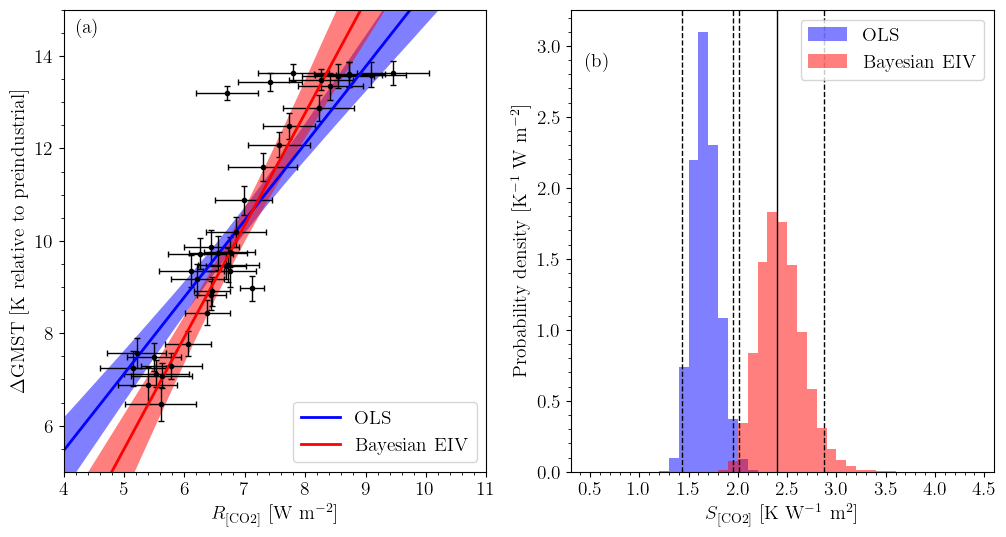

In [35]:
fig = plt.figure(figsize=(12,6))

###### Plot example regression
plt.subplot(1,2,1)
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel(r'$R_{[\mathrm{CO2}]}$ [W m$^{-2}$]',fontsize=fontsize)
plt.ylabel(r'$\Delta$GMST [K relative to preindustrial]',fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xlim([4,11])
plt.ylim([5,15])

plt.fill_between(xplot,OLS_CI[:,0],y2=OLS_CI[:,2],color='b',alpha=0.5,edgecolor=None)
plt.plot(xplot,OLS_CI[:,1],'b',linewidth=2,label='OLS')

plt.fill_between(xplot,MCMC_CI[:,0],y2=MCMC_CI[:,2],color='r',alpha=0.5,edgecolor=None)
plt.plot(xplot,MCMC_CI[:,1],'r',linewidth=2,label='Bayesian EIV')

plt.text(4.2,14.5,'(a)',fontsize=fontsize)
plt.legend(fontsize=fontsize,loc='lower right')

###### plot MC histograms
plt.subplot(1,2,2)
bin_edges = np.arange(0.5, 4.5, 0.1)

plt.hist(pOLS[:,0],bins=bin_edges,density=True, alpha = 0.5,color='b', label = "OLS");
plt.hist(pMCMC[:,0],bins=bin_edges,density=True, alpha = 0.5,color='r', label = "Bayesian EIV");
plt.minorticks_on()
plt.xlabel(r'$S_{[\mathrm{CO2}]}$ [K W$^{-1}$ m$^2$]',fontsize=fontsize)
plt.ylabel(r'Probability density [K$^{-1}$ W m$^{-2}$]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().axvline(x=np.percentile(pOLS[:,0],2.5), color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=np.percentile(pOLS[:,0],97.5), color='k', linestyle='--', linewidth=1)

CI = credible(pMCMC[:,0],0.95)
plt.gca().axvline(x=CI[0], color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=CI[1], color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=find_MAP(pMCMC[:,0]), color='k', linestyle='-', linewidth=1)

plt.text(0.45,2.85,'(b)',fontsize=fontsize)
plt.legend(fontsize=fontsize);